# Imports

In [54]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

# Pure python function

In [68]:
def build_up_b_pure(b, rho, dt, u, v, dx, dy):
    row, col = p.shape  
    for i in range(1,row-1):
        for j in range(1,col-1):
            b[i,j] = rho*(dx*dy)**2*(((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))/dt-(u[i+1,j]-u[i-1,j])**2/(4*dx*dx)-2*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])/(4*dy*dx)-(v[i,j+1]-v[i,j-1])**2/(4*dy*dy))/(2*(dx**2+dy**2))
    return b

def pressure_poisson_pure(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            p[i,j] = (pn[i+1,j] + pn[i-1,j])*dy**2 + (pn[i,j+1] + pn[i,j-1])*dy**2
            p[i,j] = p[i,j]/(2*(dx**2 + dy**2)) - b[i,j]
    # Setting bondary conditions
    p[0,:] = p[1,:]
    p[:,0] = p[:,1]
    p[row-1,:] = p[row-2,:]
    p[:,col-1] = 0    
    return p

def cavity_flow_pure(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    b  = np.zeros((ny, nx))
    row, col = b.shape
    # Setting the initial conditions
    u[:, col-1] = 1
    un = np.empty_like(u)
    vn = np.empty_like(v) 
    for k in range(nt):
        un = u.copy()
        vn = v.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - dt*un[i,j]*(un[i,j] - un[i,j-1])/dx 
                u[i,j] = u[i,j] - dt*vn[i,j]*(un[i,j] - un[i,j-1])/dy
                u[i,j] = u[i,j] - dt*(p[i+1,j] - p[i-1,j])/(rho*2*dx) 
                u[i,j] = u[i,j] + nu*dt*(un[i+1,j] - 2*un[i,j] + un[i-1,j])/dx**2 
                u[i,j] = u[i,j] + nu*dt*(un[i,j+1] - 2*un[i,j] + un[i,j-1])/dy**2
                
                v[i,j] = vn[i,j] - dt*un[i,j]*(vn[i,j] - vn[i,j-1])/dx
                v[i,j] = v[i,j] - dt*vn[i,j]*(vn[i,j] - vn[i,j-1])/dy
                v[i,j] = v[i,j] - dt*(p[i,j+1] - p[i,j-1])/(rho*2*dx)
                v[i,j] = v[i,j] + nu*dt*(vn[i+1,j] - 2*vn[i,j] + vn[i-1,j])/dx**2
                v[i,j] = v[i,j] + nu*dt*(vn[i,j+1] - 2*vn[i,j] + vn[i,j-1])/dy**2
        
        b = build_up_b_pure(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_pure(p, dx, dy, b)
    return u, v, p

# Numba accelerator

In [69]:
@njit(fastmath = True)
def build_up_b_numba(b, rho, dt, u, v, dx, dy):
    row, col = p.shape  
    for i in range(1,row-1):
        for j in range(1,col-1):
            b[i,j] = rho*(dx*dy)**2*(((u[i+1,j]-u[i-1,j])/(2*dx)+(v[i,j+1]-v[i,j-1])/(2*dy))/dt-(u[i+1,j]-u[i-1,j])**2/(4*dx*dx)-2*(u[i,j+1]-u[i,j-1])*(v[i+1,j]-v[i-1,j])/(4*dy*dx)-(v[i,j+1]-v[i,j-1])**2/(4*dy*dy))/(2*(dx**2+dy**2))
    return b

@njit(fastmath = True)
def pressure_poisson_numba(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()
    row, col = b.shape
    for i in range(1,row-1):
        for j in range(1,col-1):
            p[i,j] = (pn[i+1,j] + pn[i-1,j])*dy**2 + (pn[i,j+1] + pn[i,j-1])*dy**2
            p[i,j] = p[i,j]/(2*(dx**2 + dy**2)) - b[i,j]
    # Setting bondary conditions
    p[0,:] = p[1,:]
    p[:,0] = p[:,1]
    p[row-1,:] = p[row-2,:]
    p[:,col-1] = 0    
    return p

@njit(fastmath = True)
def cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu):
    # Setting the initial conditions
    b  = np.zeros((ny, nx))
    row, col = b.shape
    u[:, col-1] = 1
    un = np.empty_like(u)
    vn = np.empty_like(v)
    for k in range(nt):
        un = u.copy()
        vn = v.copy()
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] - dt*un[i,j]*(un[i,j] - un[i,j-1])/dx 
                u[i,j] = u[i,j] - dt*vn[i,j]*(un[i,j] - un[i,j-1])/dy
                u[i,j] = u[i,j] - dt*(p[i+1,j] - p[i-1,j])/(rho*2*dx) 
                u[i,j] = u[i,j] + nu*dt*(un[i+1,j] - 2*un[i,j] + un[i-1,j])/dx**2 
                u[i,j] = u[i,j] + nu*dt*(un[i,j+1] - 2*un[i,j] + un[i,j-1])/dy**2
                
                v[i,j] = vn[i,j] - dt*un[i,j]*(vn[i,j] - vn[i,j-1])/dx
                v[i,j] = v[i,j] - dt*vn[i,j]*(vn[i,j] - vn[i,j-1])/dy
                v[i,j] = v[i,j] - dt*(p[i,j+1] - p[i,j-1])/(rho*2*dx)
                v[i,j] = v[i,j] + nu*dt*(vn[i+1,j] - 2*vn[i,j] + vn[i-1,j])/dx**2
                v[i,j] = v[i,j] + nu*dt*(vn[i,j+1] - 2*vn[i,j] + vn[i,j-1])/dy**2
        
        b = build_up_b_numba(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson_numba(p, dx, dy, b)
    return u, v, p

# Inputs

Text(0, 0.5, 'Y')

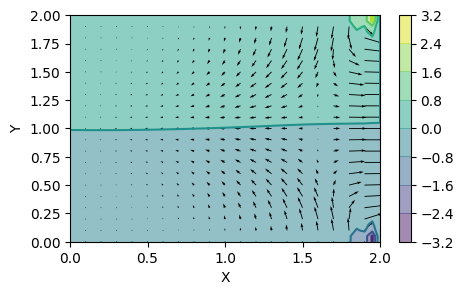

In [70]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))

u, v, p = cavity_flow_numba(nt, u, v, dt, nx, ny, dx, dy, p, rho, nu)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y')

Text(0, 0.5, 'Y')

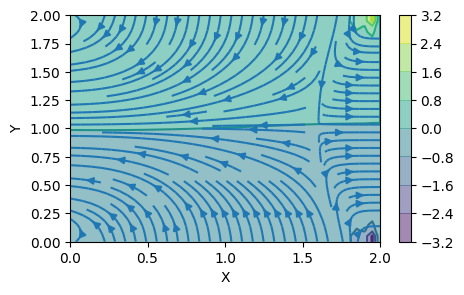

In [71]:
fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y')

# Call Functions

# Pure function

In [72]:
%timeit cavity_flow_pure(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

1 loop, best of 3: 14.7 s per loop


# Function with numba accelerator

In [73]:
%timeit cavity_flow_numba(nt, u, v, dt, ny, ny, dx, dy, p, rho, nu)

10 loops, best of 3: 19.7 ms per loop
